# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

# Game of Life implementation

In [ ]:
# Imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import fftpack
from functools import partial
from IPython.display import Image

To implement the Conway's Game of Life we start with an initial configuration (seed) stored in a grid as a multidimensional numpy array.
At each time step the `update()` function is called to update the grid applying the GoF rules.
This function handles all the logic of the game and it's built to allow us to run some analysis on the evolution of the game.

Many different types of patterns occur in GoF, the most common are classified according to their behaviour and can be found [here](https://conwaylife.com/patterns/).
In particular we use `loadPattern()` function to import particular patterns we want to study, sparing us the time to manually implement them.

Finally, we store all the generated frames in ``.gif`` file to show the final result.

In [205]:
# Parameters
ON = 255  # Alive cell value
OFF = 0   # Dead cell value

n_steps = 50 # Number of steps done in the game
inter = 100  # Time in ms between each frame (step of the game) in the GIF


def update(frame_num, img, grid, initial_grid=None, cycle=None, occupancy=None, heat=None):
    """
    Update the pattern applying the GoF rules.
    This function takes a numpy array representing the state of the pattern at a specific step specified by frame_num.
    If initial_grid and cycle arguments are passed, it checks if the new computed condition is equal to the starting one, 
    keeping track of when it happens.
    If occupancy argument is passed, it calculate how many cells are alive at that step.
    If the heat argument is passed, it computes the difference in occupancy between present and future grid, 
    keeping track of changes and averaging it at the end of the animation.
    
    Parameters
    ----------
    frame_num : Current step number
    img : Input image
    grid : Present state (numpy array)
    initial_grid : Initial state
    cycle : List of cycle flags: i-th element is 1 if the pattern has cycled at current step 0 otherwise
    occupancy : List of numbers of alive cells at each step
    heat : List of numbers of cells that changed state at each step
    
    Returns
    -------
    img : Output image
    """
    
    # Create a new grid for future state
    newGrid = grid.copy()

    # Save the number of rows and columns
    Nr = grid.shape[0]
    Nc = grid.shape[1]
    
    for i in range(Nr):
        for j in range(Nc):
            # For each cell in the grid it calculate the number of neighbouring alive cells
            total = int((grid[i, (j-1)%Nc] + grid[i, (j+1)%Nc] +
                         grid[(i-1)%Nr, j] + grid[(i+1)%Nr, j] +
                         grid[(i-1)%Nr, (j-1)%Nc] + grid[(i-1)%Nr, (j+1)%Nc] +
                         grid[(i+1)%Nr, (j-1)%Nc] + grid[(i+1)%Nr, (j+1)%Nc]) / ON)

            # Any live cell with fewer than two live neighbours or more than three live neighbours dies
            # otherwise with two or three live neighbours lives.
            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
                    
            # Any dead cell with exactly three live neighbours becomes a live cell.
            else:
                if total == 3:
                    newGrid[i, j] = ON

    # Save new image
    img.set_data(newGrid)

    # Keep track of how many cells change state
    if heat is not None:
        heat.append(np.sum(np.not_equal(grid,newGrid)))

    # Check if the patterns has cycled or not
    if initial_grid is not None and cycle is not None:
        cycle.append(1 if np.array_equal(newGrid,initial_grid) else 0)

    # Count how many alive cells
    if occupancy is not None:
        occupancy.append(np.sum(newGrid == ON))

    # Update the grid
    grid[:] = newGrid[:]
    
    return img


def loadPattern(file_path, rows=None, columns=None, loc=(0,0)):
    """
    Load an initial pattern from file.
    Initial position and grid size can be specified.
 
    Parameters
    ----------
    file_path : Path to input pattern
    rows : Position along rows
    columns : Position along columns
    loc : Grid size
    
    Returns
    -------
    grid : initial pattern
    """
    
    # Open file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Remove whitespaces and ignore lines starting with '!'
    lines = [line.strip() for line in lines if not line.startswith('!')]

    # Check if the number of rows and columns were specified
    if rows == None:
        rows = len(lines)
    if columns == None:
        columns = max(len(line) for line in lines) 
    
    # Pad shorter lines with zeros to make them equal in length
    max_length = max(len(line) for line in lines) 
    lines_padded = [line.ljust(max_length, '.') for line in lines]
    
    # Create the grid and the pattern
    grid = np.zeros((rows, columns))
    pattern = np.array([[0 if cell == '.' else 255 for cell in line] for line in lines_padded])
    
    # Check if parameters are ok
    if loc[0] > rows or loc[1] > columns:
        raise ValueError("Invalid location parameter")
    
    if loc[0] + pattern.shape[0] > rows or loc[1] + pattern.shape[1] > columns:
        raise ValueError("The pattern overflows the grid")
    
    # Put the pattern in the grid
    grid[loc[0]:loc[0]+pattern.shape[0], loc[1]:loc[1]+pattern.shape[1]] = pattern
    
    # Return the grid
    return grid


def saveFrame(num_frame, img):
    """
    Save a specific frame of the game.
    
    Parameters
    ----------
    frame_num : Current step number
    img : Input image
    
    Returns
    -------
    img : Output image
    """
    
    plt.savefig(f'gof_frame_{num_frame:03d}.png', format='png')
    return img

Regarding the analysis, we mainly study the occupancy (how many alive cells there are at every step of the game), the heat (the number of cells that change state at each step) and their averages.
For patterns which return to their initial state after a finite number of steps we also analyise the period.

In [204]:
def computeFFT(x):
    """
    Compute the FFT of an input signal.

    Parameters
    ----------
    x : input list
    
    Returns
    -------
    period : period of the input
    """

    # Get FFT of the signal
    fft = fftpack.fft(x)

    power = np.abs(fft)
    sample_freq = fftpack.fftfreq(len(x))

    # Find the peak frequency: focus only on only the positive frequencies
    freqs = sample_freq[np.where(sample_freq > 0)]
    powes = power[np.where(sample_freq > 0)]

    peak_freq = freqs[powes.argmax()]

    period = round(1/peak_freq)
    
    return period


def analyseOccupancy(occupancy, check_freq=False):
    """
    Plot the evolution over time of the number of alive cells and the average.
    If specified print the period of this number.

    Parameters
    ----------
    occupancy : List of alive cells at every step
    check_freq : Flag to compute the FFT of the input
    """
    
    n_occ = len(occupancy)

    # Compute the average of occupancy
    if n_occ > 0:
        avg_occ = round(np.sum(occupancy) / n_occ)
        print(f"On average there are {avg_occ} alive cells in {n_occ} steps.")

    # Compute the period of occupancy
    if check_freq:
        print(f'The number of alive cells cycles every {computeFFT(occupancy)} steps')

    # Plot occupancy and average value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_occ), occupancy, marker="o", label='Occupancy')
    ax.axhline(avg_occ,label='Avg. occupancy', color='r')
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('No. alive cells')
    
    plt.title('Occupancy vs time')
    plt.legend()
    plt.tight_layout()


def analyseHeat(heat, check_freq=False):
    """
    Plot the evolution over time of the number of cells that change state at each step and the average.
    If specified print the period of this number.

    Parameters
    ----------
    heat : List of number of cells that change state at every step
    check_freq : Flag to compute the FFT of the input
    """
    
    n_heat = len(heat)

    # Compute the average of heat
    if n_heat > 0:
        avg_heat = round(np.sum(heat) / n_heat)
        print(f"The average number of cells that change state at each generation is {avg_heat}.")

    # Compute the period of occupancy
    if check_freq:
        print(f"The number of cells that change state cycles every {computeFFT(heat)} steps")

    # Plot heat and average value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_heat), heat, marker="o", label='State changes')
    ax.axhline(avg_heat, label='Avg. state changes', color='r')
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('No. of state change')
    
    plt.title('No. cells that change state vs time')
    plt.legend()
    plt.tight_layout()


def analyseCycle(cycle):
    """
    Plot the evolution over time of pattern cycles.

    Parameters
    ----------
    cycle : List of cycle flags: i-th element is 1 if the pattern has cycled at current step 0 otherwise
    check_freq : Flag to compute the FFT of the input
    """
    
    n_cycle = len(cycle)

    # Compute the period of cycle
    print(f"The number of steps required to return to the original configuration is {computeFFT(cycle)}")

    # Plot cycle
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_cycle), cycle, marker="o")
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('Cycle')
    
    plt.title('Cycle vs Time')
    plt.tight_layout()

# Random example
In this section we initialize the game with a random generatly seed and let it evolve.

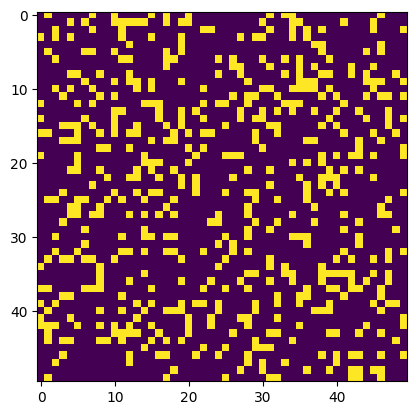

In [206]:
# Set the size of the grid
N = 50

# Generate a random grid
random_grid = np.random.choice([ON, OFF], N*N, p=[0.2, 0.8]).reshape(N, N)

# How many alive cells at each step
random_occupancy = []

# How many cells change state at each step
random_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(random_grid, interpolation='nearest')
plt.plot()

# Set up the animation and save the first frame
random_out = animation.FuncAnimation(fig, 
                            partial(update, img = img, grid = random_grid,
                                    occupancy = random_occupancy, heat = random_heat),
                            frames = n_steps, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [207]:
# Save and show animation
gif_name = 'random_example.gif'
random_out.save(gif_name, writer = 'pillow', fps = 5)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
TODO: add comment

On average there are 353 alive cells in 50 steps.


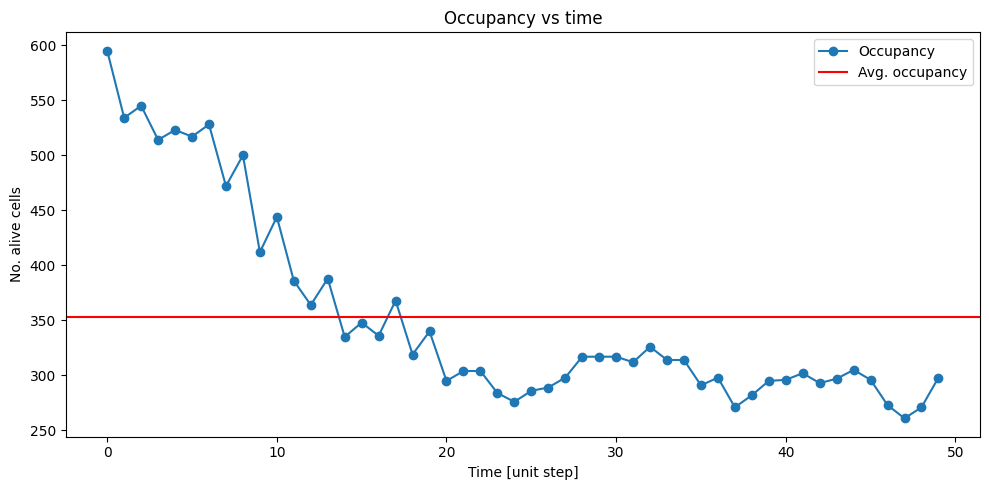

In [208]:
analyseOccupancy(random_occupancy)

The average number of cells that change state at each generation is 314.


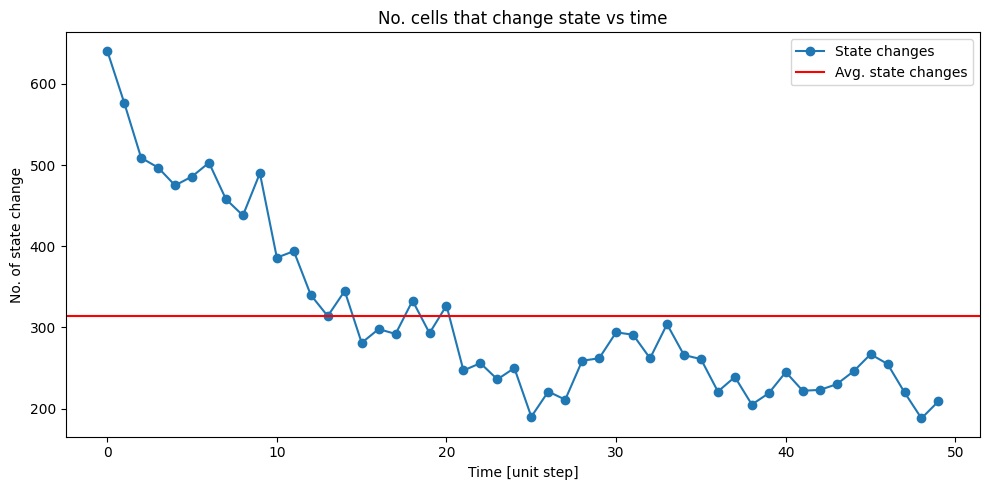

In [209]:
analyseHeat(random_heat)

# Still life example
In this section we start with a particular pattern (Beehive at loaf) from the category called _Still life_.<br>
As its name suggest, with this seed the game doesn't evolve: the alive cells are always the same both in number and in location, it's an equilibrium point.

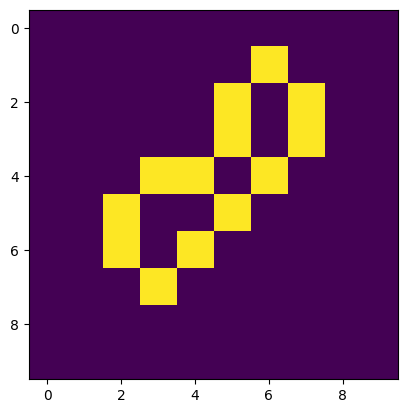

In [210]:
# Load pattern from file.
still_pattern = 'beehiveatloaf.cells.txt'
still_grid = loadPattern(still_pattern, 10, 10, (1, 2))

# How many alive cells at each step
still_occupancy = []

# How many cells change state at each step
still_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(still_grid, interpolation='nearest')
plt.plot()

# Set up the animation and save the first frame
still_out = animation.FuncAnimation(fig, partial(update, img=img, grid=still_grid,
                                                occupancy=still_occupancy, heat=still_heat),
                            frames=n_steps, interval=inter,
                            init_func=lambda: saveFrame(0, img))

In [211]:
# Save and show animation
gif_name = 'beehiveatloaf.gif'
still_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
TODO: add comment

On average there are 13 alive cells in 50 steps.


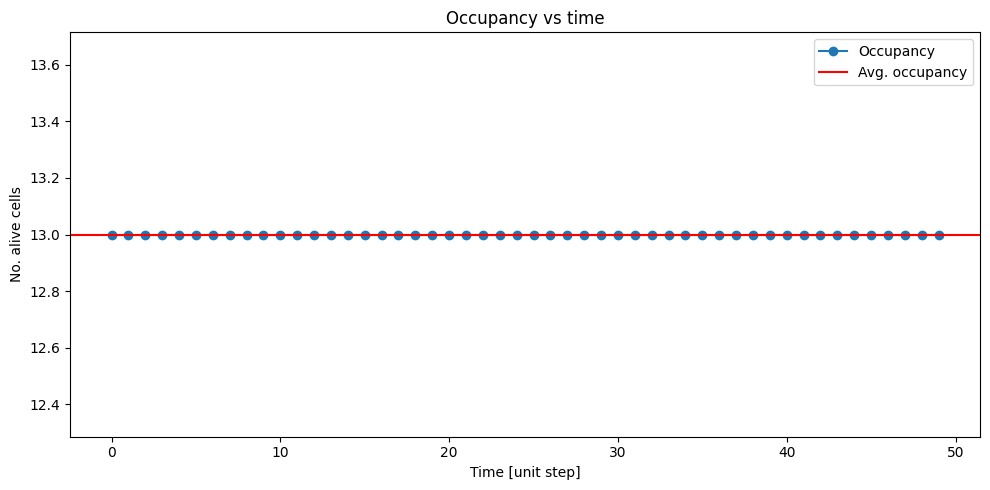

In [212]:
analyseOccupancy(still_occupancy)

The average number of cells that change state at each generation is 0.


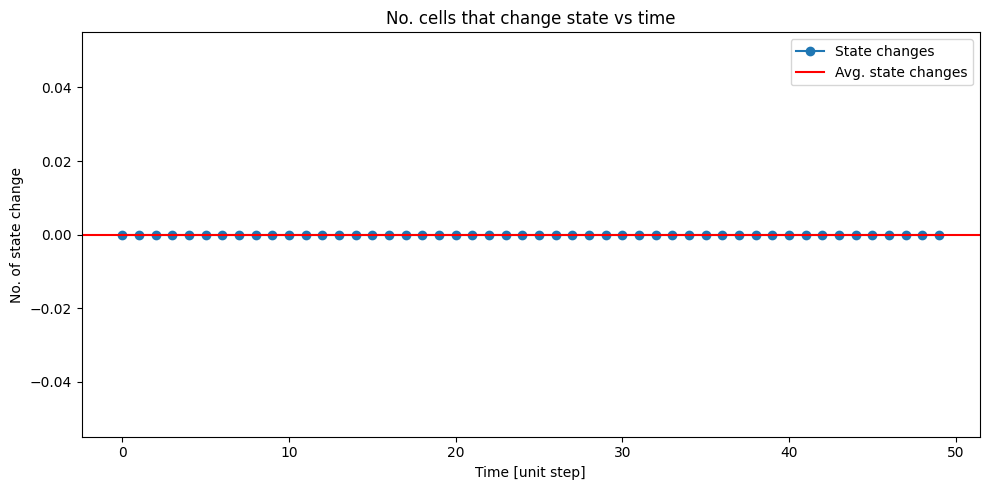

In [213]:
analyseHeat(still_heat)

# Glider example
In this section we start with a particular pattern (_Big Glider_) from the category called _Spaceships_ for theirs similarity with an animation of an object flying in the sky.<br>

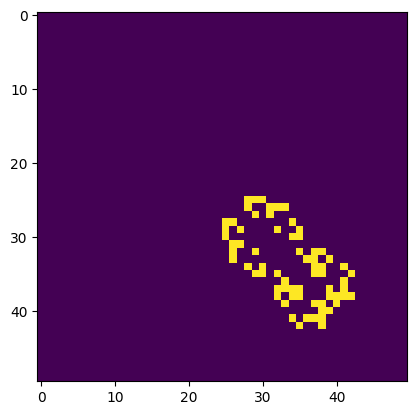

In [214]:
# Load patterns from file
glider_pattern = 'bigglider.cells.txt'
glider_grid = loadPattern(glider_pattern, 50, 50, (25,25))

# How many alive cells at each step
glider_occupancy = []

# How many cells change state at each step
glider_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(glider_grid, interpolation='nearest')
plt.plot()

# Set up the animation
glider_out = animation.FuncAnimation(fig, partial(update, img = img, grid = glider_grid, 
                                                  occupancy = glider_occupancy, heat = glider_heat),
                            frames = n_steps, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [215]:
# Save and show animation
gif_name = 'bigglider.gif'
glider_out.save(gif_name, writer='pillow', fps=4)


Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
TODO: add comment

On average there are 67 alive cells in 50 steps.
The number of alive cells cycles every 4 steps


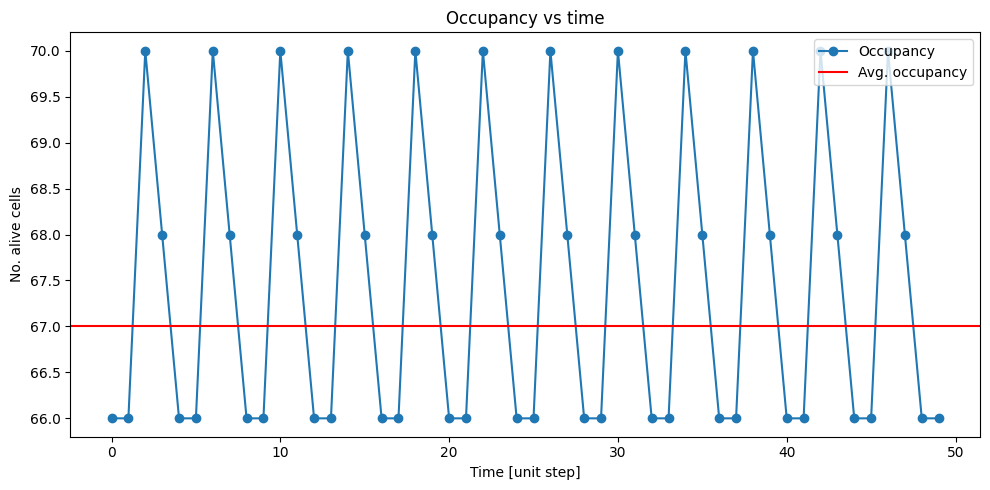

In [216]:
analyseOccupancy(glider_occupancy, True)

The average number of cells that change state at each generation is 61.
The number of cells that change state cycles every 4 steps


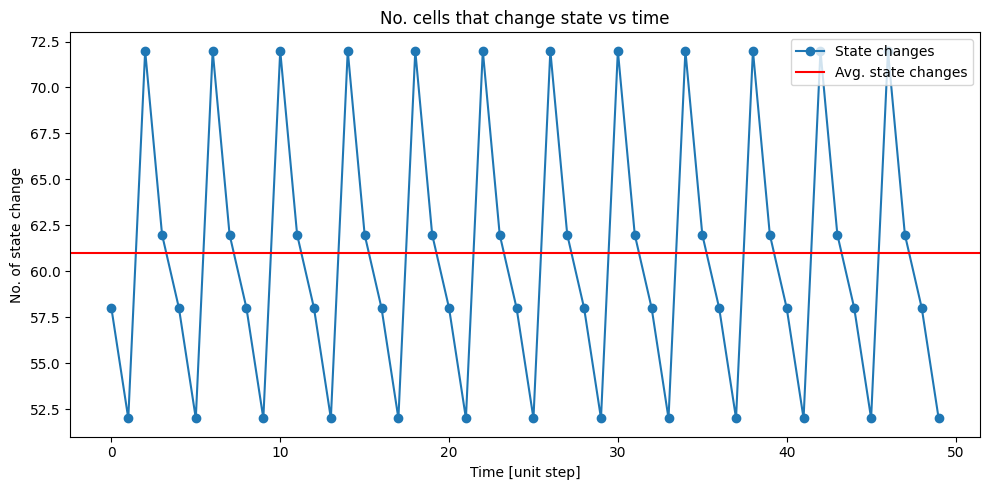

In [217]:
analyseHeat(glider_heat, True)

# Oscillator example
In this section we study a particular pattern (Pulsar3) of the cateogry _Oscillator_: Patterns which return to their initial state after a finite number of generations.

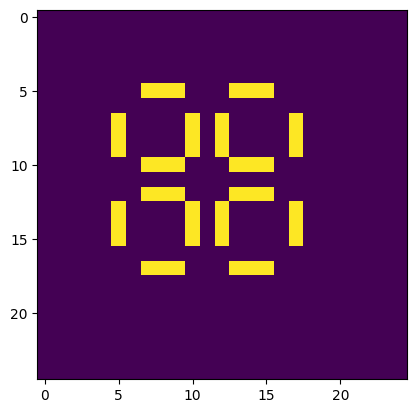

In [218]:
# Load patterns from file.
pulsar = 'pulsar_cells.cells.txt'
pulsar_grid = loadPattern(pulsar, 25,25, (5,5))

# Original configuration
pulsar_igrid = pulsar_grid.copy() 

# List of cycle flags:
# 1 if the pattern returned to the original configuration at i-th step; 
# 0 otherwise
pulsar_cycle = []

# How many alive cells at each step
pulsar_occupancy = []

# How many cells change state at each step
pulsar_heat = [];

# Plot initial seed
fig, ax = plt.subplots()
img = ax.imshow(pulsar_grid, interpolation='nearest')
plt.plot()

# Set up the animation
pulsar_out = animation.FuncAnimation(fig, 
                            partial(update, img = img, grid = pulsar_grid, initial_grid = pulsar_igrid, 
                                    cycle = pulsar_cycle, occupancy = pulsar_occupancy, heat = pulsar_heat),
                            frames = n_steps, interval = inter,
                            init_func = lambda: saveFrame(0, img))

In [219]:
# Save and show animation
gif_name = 'pulsar_period3.gif'
pulsar_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

<Figure size 640x480 with 0 Axes>

## Analysis
TODO: add comment

On average there are 59 alive cells in 50 steps.
The number of alive cells cycles every 3 steps


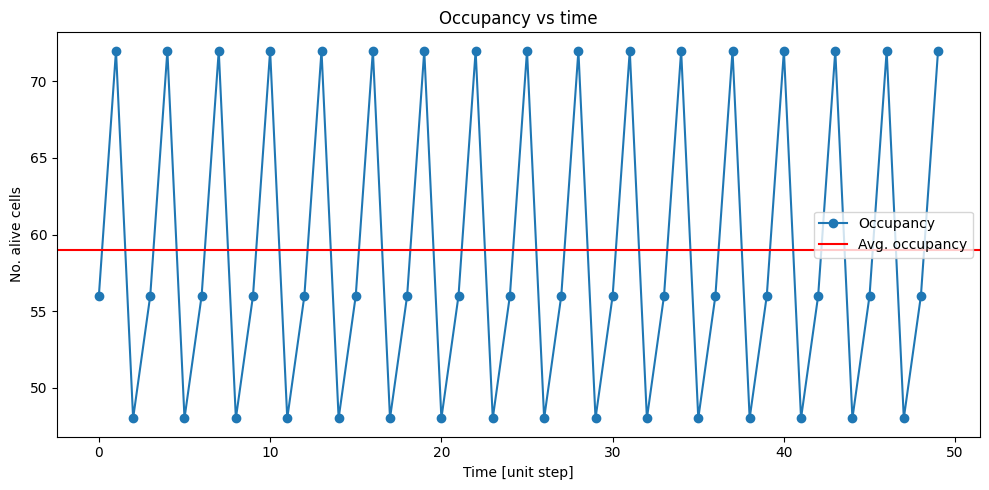

In [220]:
analyseOccupancy(pulsar_occupancy, True)

The average number of cells that change state at each generation is 43.
The number of cells that change state cycles every 3 steps


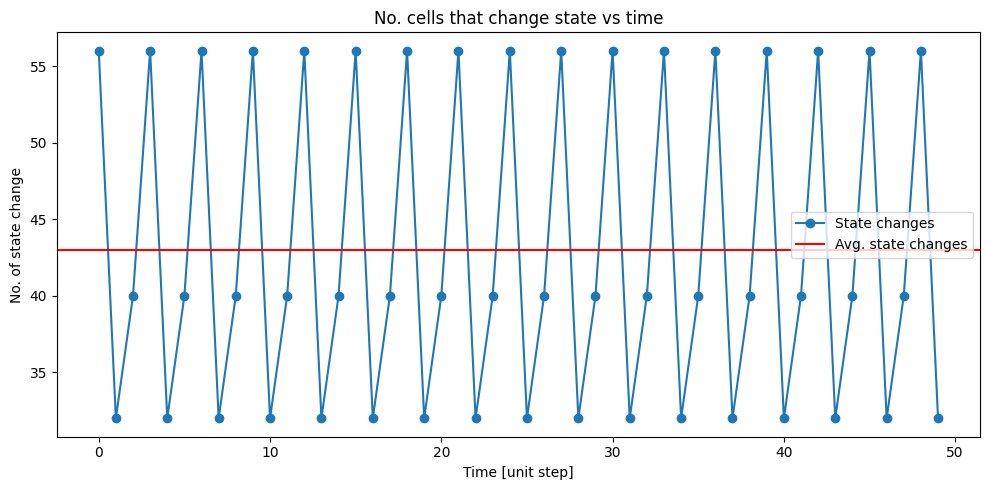

In [221]:
analyseHeat(pulsar_heat, True)

The number of steps required to return to the original configuration is 3


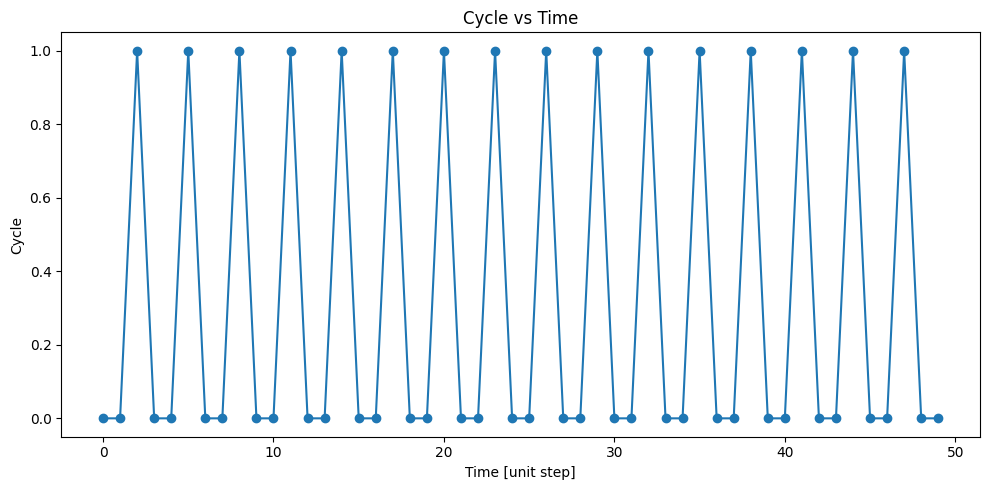

In [222]:
analyseCycle(pulsar_cycle)

# Complex pattern
TODO: find a more big and complex pattern and analyse it.